# Recreate figure 2 from Kay (2012)

FIG. 2. Global maps of observed and COSP-simulated annual mean total cloud fraction:  
(a) ISCCP observations (t > 0.3),  
(b) MISR observations (t > 0.3),  
(c) CALIPSO GOCCP observations (SR > 5),  
(d) CAM4 ISCCP,  
(e) CAM4 MISR, 
(f) CAM4 CALIPSO, 
(g) CAM5 ISCCP,  
(h) CAM5 MISR, and  
(i) CAM5 CALIPSO. 

The value after each panel name reports the global annual mean, while the values in parentheses report the global annual mean model bias (CAM 2 observations) and model RMSE, respectively. Because they do not include optically thin or broken clouds, the global annual mean cloud fractions observed by MODIS (0.49) and CloudSat (0.50) are significantly smaller than those observed by CALIOP, MISR, or ISCCP and are not included in this plot. The solid gray line in each panel shows the GCSS Pacific cross section.

### Add paths to run locally or off Cheyenne or Casper 
(what is the difference between these two again?)

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png,calculate,dual_mask
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# In the CAM output, the ISCCP total is named "CLDTOT_ISCCP"

### Find the files

In [3]:
case_dir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012/'

### Load post-processed CAM4 and CAM5 files into a cloud metric

In [4]:
fig2metric = Cloud_Metric(case_dir)
fig2metric.add_case('cam4_1deg_release_amip',label='CAM4')
fig2metric.add_case('cam5_1deg_release_amip',label='CAM5')
fig2metric.add_case(case='f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1',path='/glade/p/cesm/pcwg/jenkay/COSP/cesm21/',label='CAM6 CMIP6 AMIP')


Loading GOCCP data...done.
Loading CALIOP SLFs...Could not load cloudtop CALIOP slfs from caliop_olimpia/ct_slf_olimpia/cloudtop_slfs.nc
Loading CERES-EBAF fluxes...done.
Loading ISCCP cloud total...done.
Loading MISR cloud histograms...done.
Loading MODIS cloud histograms...done.
Processed timeseries directory found for cam4_1deg_release_amip. Will load data as required.
cam4_1deg_release_amip load successfully.
Processed timeseries directory found for cam5_1deg_release_amip. Will load data as required.
cam5_1deg_release_amip load successfully.
Processed timeseries directory found for f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1. Will load data as required.
f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1 load successfully.


### Variable loading

In [5]:
fig2metric.load_vars(['LANDFRAC','ICEFRAC','CLDTOT_MISR','CLD_MISR']);#,'CLDTOT_ISCCP','CLDTOT_CAL']);

Not able to find unique timeseries file for CLDTOT_MISR in CAM6 CMIP6 AMIP


#### Manually add the CAM6 file because I don't have access

In [6]:
cam6_da = fig2metric.get_case('f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1').case_da

In [7]:
cam6_tempdir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012'
cam6_runname = 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'

if not os.path.exists('%s/%s/%s.cam.h0.CLDTOT_MISR.197901-201412.nc' % (cam6_tempdir,cam6_runname,cam6_runname)):
    print('calculating anew')
#     break

    cltmisr_cam6 = cam6_da['CLD_MISR'].where(cam6_da['CLD_MISR'].cosp_tau>0.3).sum(dim=['cosp_tau','cosp_htmisr'])
    cam6_da['CLDTOT_MISR'] = cltmisr_cam6
    cltmisr_cam6.to_netcdf('%s/%s/%s.cam.h0.CLDTOT_MISR.197901-201412.nc' % (cam6_tempdir,cam6_runname,cam6_runname))
else:
    print('loading precomputed file')
#     break
    cltmisr_cam6 = xr.open_dataset('%s/%s/%s.cam.h0.CLDTOT_MISR.197901-201412.nc' % (cam6_tempdir,cam6_runname,cam6_runname))
    cam6_da['CLDTOT_MISR'] = cltmisr_cam6['CLD_MISR']

loading precomputed file


In [8]:
# cam6_tempdir = '/glade/u/home/jonahshaw/w/archive/Kay_COSP_2012'
# cam6_runname = 'f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'
# cam6_cldtot_misr = xr.open_dataset('%s/%s/%s.cam.h0.CLDTOT_MISR.197901-201412.nc' % (cam6_tempdir,cam6_runname,cam6_runname))

In [9]:
# cam6_cldtot_misr['CLDTOT_MISR'].sel(time=slice('2001-01-01', '2010-12-31')).mean('time').plot()

### Fix

make sure the CLDTOT_MISR files have 'time_bnds' in them when you save.

In [10]:
# cam6_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'

In [11]:
# os.listdir('%s/%s' % (cam6_dir,'atm/proc/tseries/month_1/'))

In [12]:
# os.listdir('%s/%s' % (cam6_dir,'atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLD_MISR.197901-201412.nc'))


In [13]:
# testy = xr.open_dataset('%s/%s' % (cam6_dir,'atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLD_MISR.197901-201412.nc'))


In [14]:
# testy['CLDTOT_MISR'] = testy['CLD_MISR'].where(testy['CLD_MISR'].cosp_tau>0.3).sum(dim=['cosp_tau','cosp_htmisr'])

In [15]:
# testy2 = testy[['CLDTOT_MISR', 'cosp_htmisr','cosp_tau','time','time_bnds']]

In [16]:
# testy2['CLDTOT_MISR'].mean()

In [17]:
# testy2.to_netcdf('%s/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.CLDTOT_MISR.197901-201412.nc' % cam6_dir)

In [18]:
# os.listdir('%s/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1' % case_dir)

In [19]:
# testy2

In [20]:
# fig2metric.load_vars('CLD_MISR');#,'CLDTOT_ISCCP','CLDTOT_CAL']);


### Grab case_das

In [8]:
cam4_da = fig2metric.get_case('cam4_1deg_release_amip').case_da
cam5_da = fig2metric.get_case('cam5_1deg_release_amip').case_da
# cam6_da = test
# cam6_da = fig2metric.get_case('f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1').case_da

### Process CAM6 to CLDTOT_MISR

### Load original observations

In [9]:
obs2012_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'
newobs_ceresebaf = '/glade/u/home/jonahshaw/obs/CERES_EBAF/'

In [10]:
og_misr = xr.open_dataset('%s/MISR.CLDTOT_MISR.nc' % (obs2012_dir))

In [11]:
# og_misr = xr.open_dataset('%s/MISR.CLDTOT_MISR.nc' % (obs2012_dir))
# og_isccp = xr.open_dataset('%s/ISCCP.CLDTOT_ISCCPCOSP.nc' % (obs2012_dir))
# og_caliop = xr.open_dataset('%s/CALIPSO.CLDTOT_CAL.nc' % (obs2012_dir))

# # rename to match model variables
# og_isccp = og_isccp.rename({'CLDTOT_ISCCPCOSP':'CLDTOT_ISCCP'})

### Get create a MISR mask with CAM variables

#### Looks good.

In [12]:
# cam_mask = np.bitwise_and(cam5_da['LANDFRAC'] < 0.90, cam5_da['ICEFRAC'] < 0.90)
cam_mask4 = np.bitwise_and(cam4_da['LANDFRAC'] < 0.90, cam4_da['ICEFRAC'] < 1.0)
cam_mask5 = np.bitwise_and(cam5_da['LANDFRAC'] < 0.90, cam5_da['ICEFRAC'] < 1.0)
cam_mask6 = np.bitwise_and(cam6_da['LANDFRAC'] < 0.90, cam6_da['ICEFRAC'] < 1.0)

### Testing

### Assign processed data to a new variable

#### MISR

In [14]:
# need to add same resolution to DS object
# fig2metric.misr_data['CLDTOT_MISR'] = og_misr['CLDTOT_MISR'].interp_like(cam_mask) 
fig2metric.misr_data['CLDTOT_MISR'] = og_misr['CLDTOT_MISR'].interp_like(fig2metric.misr_data['CLD_MISR']) 
# cam5_da['CLDTOT_MISR'] = cam5_da['CLDTOT_MISR'].where(cam_mask)
# cam4_da['CLDTOT_MISR'] = cam4_da['CLDTOT_MISR'].where(cam_mask)
# weird assignment
# fig2metric.cases['f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'].case_da = cam6_da.where(cam_mask6)
fig2metric.cases['f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'].case_da['CLDTOT_MISR'] = cam6_da['CLDTOT_MISR'].where(cam_mask6)
fig2metric.cases['cam4_1deg_release_amip'].case_da['CLDTOT_MISR'] = cam4_da['CLDTOT_MISR'].where(cam_mask4)
fig2metric.cases['cam5_1deg_release_amip'].case_da['CLDTOT_MISR'] = cam5_da['CLDTOT_MISR'].where(cam_mask5)

## Plot finally!

In [16]:
# Functions to apply within the cloud metric
def restrict_lat60(da):
    
    return da.where(np.abs(da['lat'])<60)

def offland(da):
    
    return xr.where(cam_mask6.interp_like(da),da,np.nan)

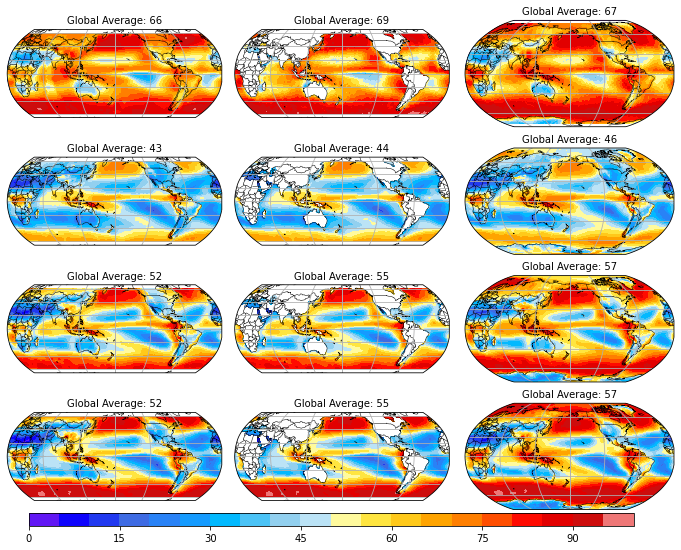

In [22]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=4, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)
ax1 = axs[:,0]
ax2 = axs[:,1]
ax3 = axs[:,2]

fig.subplots_adjust(wspace=0.06)

cldisccp = fig2metric.plot2D('CLDTOT_ISCCP',projection='Robinson',ax=ax1,
                             contour=True,levels=np.linspace(0,100,21),
                             extend='neither',label=False,afunc=restrict_lat60)

# cldmisr = fig2metric.plot2D('CLD_MISRp',projection='Robinson',ax=ax2,
cldmisr = fig2metric.plot2D('CLDTOT_MISR',projection='Robinson',ax=ax2,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False,afunc=restrict_lat60)

cldcal = fig2metric.plot2D('CLDTOT_CAL',projection='Robinson',ax=ax3,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldcal[1], cax=cbar_axh,orientation='horizontal')

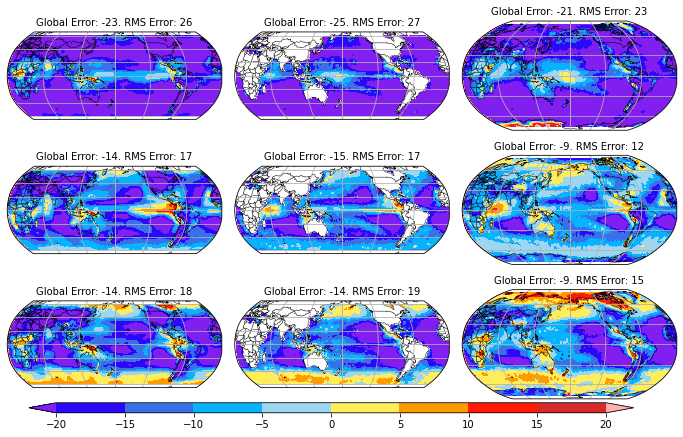

In [24]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=3, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(7)
fig.set_figwidth(12)
# fig.set_dpi(200)
ax1 = axs[:,0]
ax2 = axs[:,1]
ax3 = axs[:,2]

fig.subplots_adjust(wspace=0.06)

cldisccp = fig2metric.plot2D('CLDTOT_ISCCP',projection='Robinson',ax=ax1,
                             contour=True,levels=np.linspace(-20,20,9),
                             extend='both',label=False,bias=True,afunc=restrict_lat60)

# cldmisr = fig2metric.plot2D('CLD_MISRp',projection='Robinson',ax=ax2,
cldmisr = fig2metric.plot2D('CLDTOT_MISR',projection='Robinson',ax=ax2,
                           contour=True,levels=np.linspace(-20,20,9),
                           extend='both',label=False,bias=True,afunc=restrict_lat60)

cldcal = fig2metric.plot2D('CLDTOT_CAL',projection='Robinson',ax=ax3,
                           contour=True,levels=np.linspace(-20,20,9),
                           extend='both',label=False,bias=True)

cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldcal[1], cax=cbar_axh,orientation='horizontal')

### Plot MISR with only 60S-60N

#### Create new masks

In [58]:
# I need to use a bitwise comparison here instead of just a where command
lat_mask = np.bitwise_and(np.abs(cam_mask.lat)<60,cam_mask)
lat_mask6 = np.bitwise_and(np.abs(cam_mask6.lat)<60,cam_mask6)
                         
# lat_mask6 = cam_mask6.where(np.abs(cam_mask6.lat)<60)

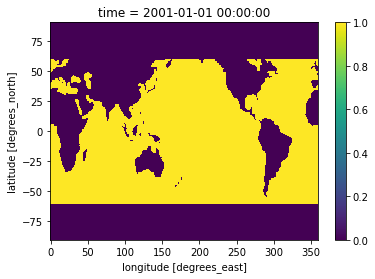

In [61]:
lat_mask[:,0,:].plot()

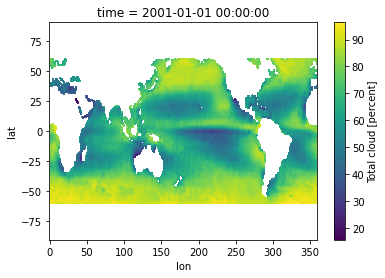

In [71]:
og_misr['CLDTOT_MISR'].interp_like(lat_mask).where(lat_mask).isel(time=0).plot()

In [75]:
og_misr['CLDTOT_MISR'].interp_like(fig2metric.misr_data).where(lat_mask)#

<xarray.DataArray 'CLDTOT_MISR' (lat: 192, lon: 288, time: 120)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2001-01-01 00:00:00 ... 2010-12-01 00:00:00
Attributes:
    units:      percent
    long_name:  Total cloud

In [76]:
# need to add same resolution to DS object
fig2metric.misr_data['CLDTOT_MISR'] = fig2metric.misr_data['CLDTOT_MISR'].where(np.abs(fig2metric.misr_data.lat) < 60)#

fig2metric.cases['f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1'].case_da['CLDTOT_MISR'] = cam6_da['CLDTOT_MISR'].where(lat_mask6)
fig2metric.cases['cam4_1deg_release_amip'].case_da['CLDTOT_MISR'] = cam4_da['CLDTOT_MISR'].where(lat_mask)
fig2metric.cases['cam5_1deg_release_amip'].case_da['CLDTOT_MISR'] = cam5_da['CLDTOT_MISR'].where(lat_mask)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_

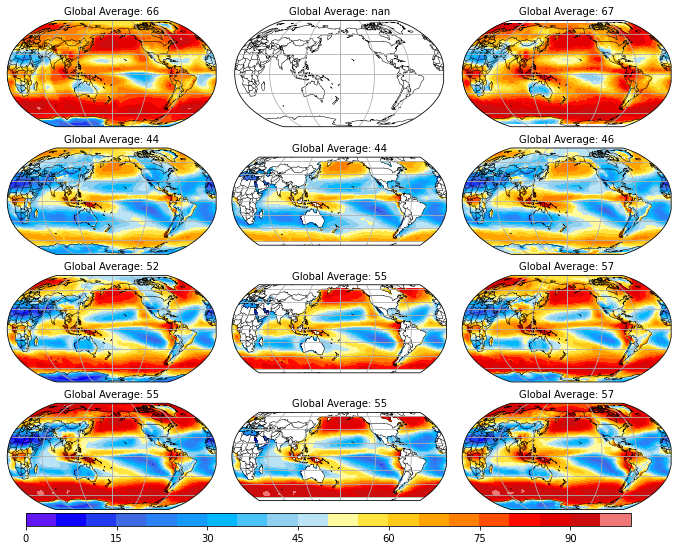

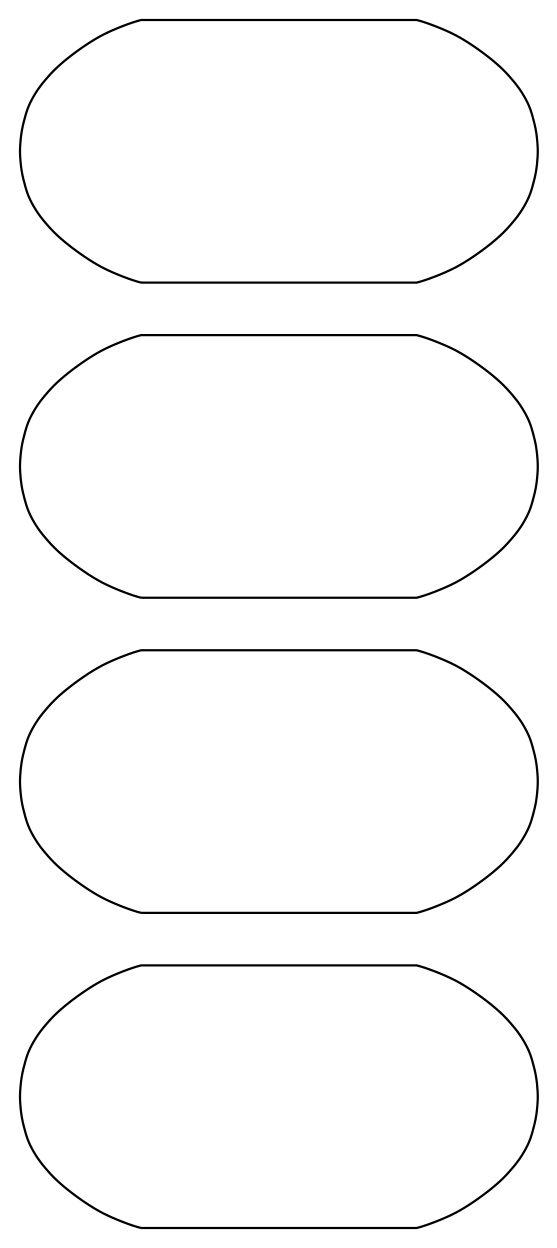

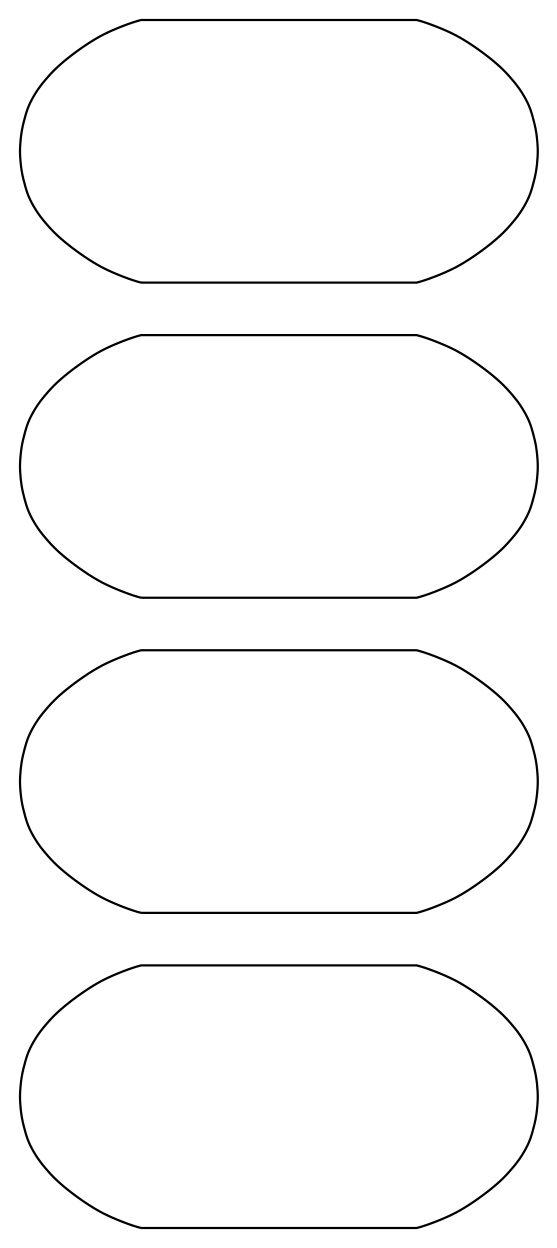

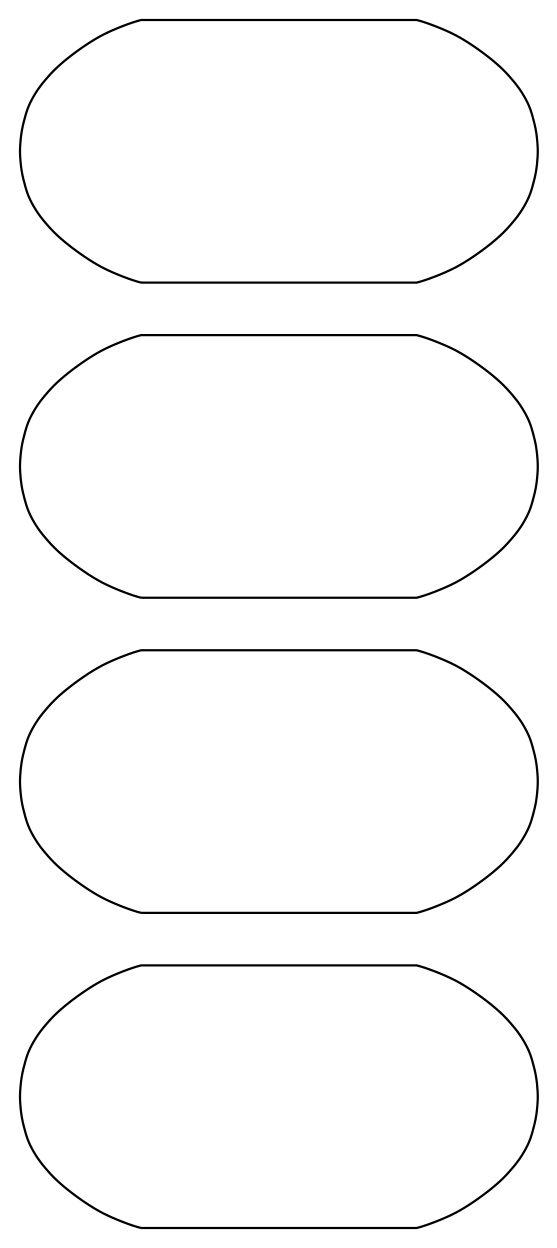

In [77]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=4, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)
ax1 = axs[:,0]
ax2 = axs[:,1]
ax3 = axs[:,2]

fig.subplots_adjust(wspace=0.06)

cldisccp = fig2metric.plot2D('CLDTOT_ISCCP',projection='Robinson',ax=ax1,
                             contour=True,levels=np.linspace(0,100,21),
                             extend='neither',label=False)

# cldmisr = fig2metric.plot2D('CLD_MISRp',projection='Robinson',ax=ax2,
cldmisr = fig2metric.plot2D('CLDTOT_MISR',projection='Robinson',ax=ax2,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cldcal = fig2metric.plot2D('CLDTOT_CAL',projection='Robinson',ax=ax3,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldcal[1], cax=cbar_axh,orientation='horizontal')

### Load original data as a cross-check

In [51]:
og_dir = '/glade/u/home/jonahshaw/w/kay2012_OGfiles'
# os.listdir(og_dir)

In [96]:
og_cltmisr = xr.open_dataset('%s/MISR.CLDTOT_MISR.nc' % (og_dir))
og_cltmisr_cam4 = xr.open_dataset('%s/CAM4.CLDTOT_MISR.nc' % (og_dir))
og_cltmisr_cam5 = xr.open_dataset('%s/CAM5.CLDTOT_MISR.nc' % (og_dir))

og_cltmisr = og_cltmisr.rename({'CLDTOT_MISR':'CLD_MISR'})
og_cltmisr_cam4 = og_cltmisr_cam4.rename({'CLDTOT_MISR':'CLD_MISR'})
og_cltmisr_cam5 = og_cltmisr_cam5.rename({'CLDTOT_MISR':'CLD_MISR'})

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLMISR' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'CLDTOT_MISR' has multiple fill values {-1e+30, -999.0}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'robust', 'add_

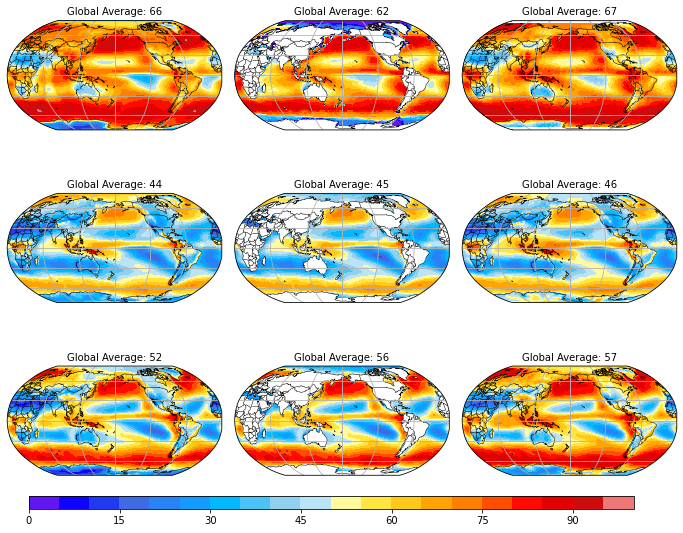

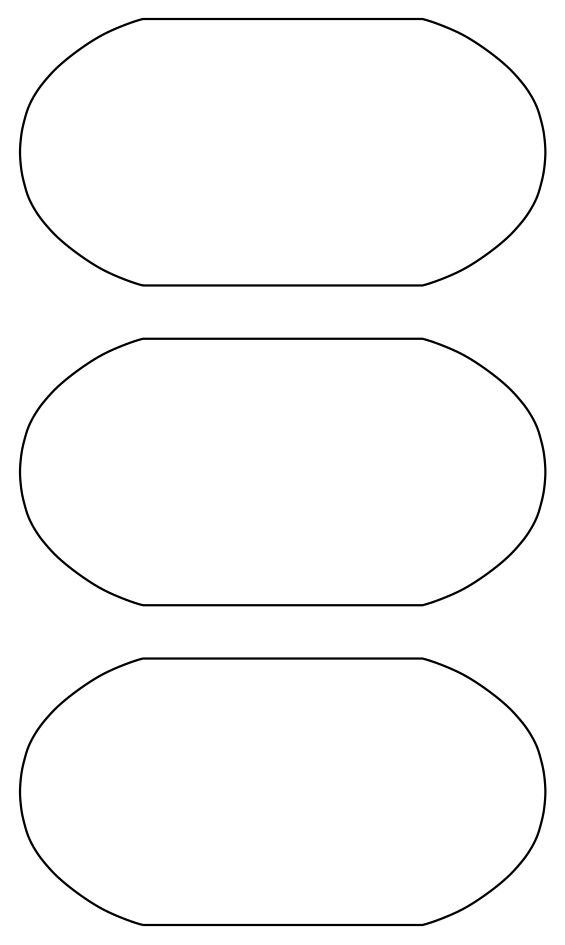

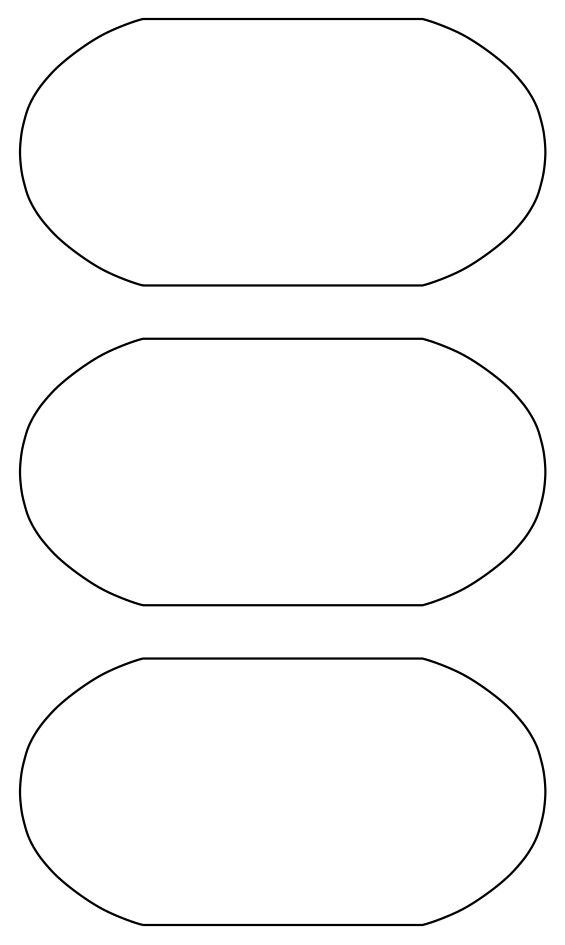

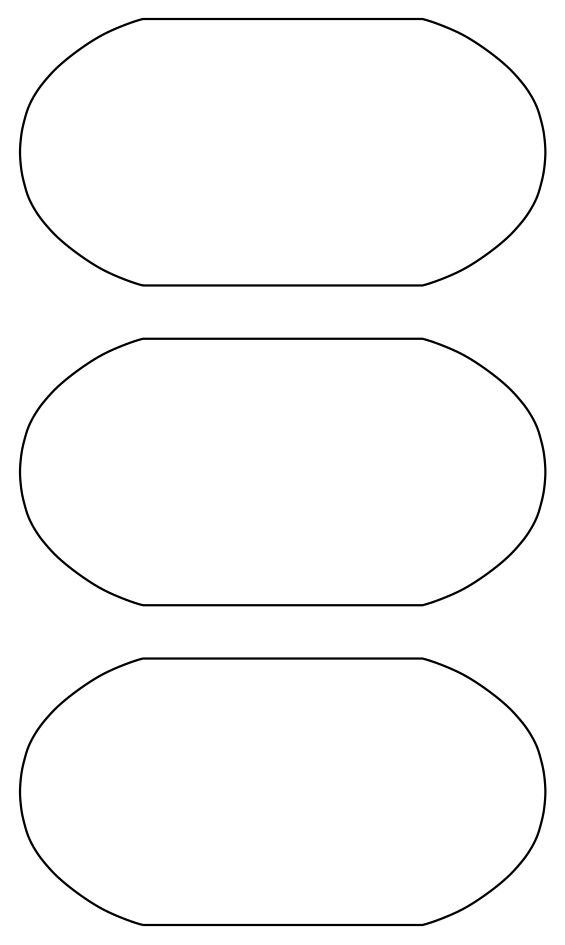

In [20]:
# fig,axs = plt.subplots(nrows=2,ncols=2,sharey='row')
fig, axs = sp_map(nrows=3, ncols=3, projection=ccrs.Robinson(central_longitude=180))#, figsize=[15,2*(len(self.cases))])

fig.set_figheight(9)
fig.set_figwidth(12)
# fig.set_dpi(200)
ax1 = axs[:,0]
ax2 = axs[:,1]
ax3 = axs[:,2]

fig.subplots_adjust(wspace=0.06)

cldisccp = fig2metric.plot2D('CLDTOT_ISCCP',projection='Robinson',ax=ax1,
                             contour=True,levels=np.linspace(0,100,21),
                             extend='neither',label=False)

cldmisr = fig2metric.plot2D('CLD_MISRp',projection='Robinson',ax=ax2,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cldcal = fig2metric.plot2D('CLDTOT_CAL',projection='Robinson',ax=ax3,
                           contour=True,levels=np.linspace(0,100,21),
                           extend='neither',label=False)

cbar_axh = fig.add_axes([0.15, 0.10, 0.70, 0.02])

fig.colorbar(cldcal[1], cax=cbar_axh,orientation='horizontal')